In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
random_state = 13121994
from mpl_toolkits import mplot3d

%matplotlib inline

In [2]:
# Load Data
X, Y = np.load('X.npy'), np.load('Y.npy')
X_test = np.load('X_test.npy')

X_m = np.concatenate((X, X_test), axis=0)

In [3]:
def convert_set_to_hgset(dataset, bins):
    size = dataset.shape[0]
    # Normalize Dataset
    dataset = dataset/(255)
    result = np.zeros((size, bins))
    
    for i in range(0, size):
        result[i], _ = np.histogram(dataset[i].ravel(), bins, [0, 1])
    
    return result

def linearize(dataset):
    size = dataset.shape[0]
    dim = dataset.shape[1] * dataset.shape[2]
    # Normalize Dataset
    dataset = dataset/(255)
    
    result = np.zeros((size, dim))
    
    for i in range(0, size):
        result[i] = dataset[i].ravel()
    
    return result

In [18]:
from sklearn.preprocessing import StandardScaler
# Normalize data
binsize = 128
scaler = StandardScaler()

X_hst = convert_set_to_hgset(X_m, binsize)
#X_hst = linearize(X_m)
scaler.fit(X_hst)

X_std = scaler.transform(X_hst)

#X_test_hst = convert_set_to_hgset(X_test, binsize)
#X_test_std = scaler.transform(X_test_hst)

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=random_state)

#X_lin = scaler.fit_transform(linearize(X))
#X_test_lin = scaler.fit_transform(linearize(X_test))

#X_tsne = tsne.fit_transform(X_lin)
#X_test_tsne = tsne.fit_transform(X_test_lin)
X_tsne = tsne.fit_transform(X_std)
#X_test_tsne = tsne.fit_transform(X_test_std)

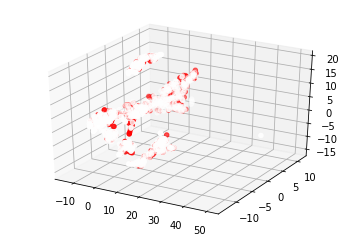

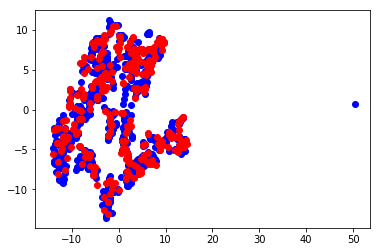

In [20]:
from mpl_toolkits import mplot3d
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.scatter(X_tsne[0:660, 0], X_tsne[0:660, 1], X_tsne[0:660, 2], color='white')
ax.scatter(X_tsne[661:, 0], X_tsne[661:, 1], X_tsne[661:, 2], color='red')

#ax.plot3D(x=X_tsne[:, 0], y=X_tsne[:, 1], z=X_tsne[:, 2 ])

plt.figure()
plt.scatter(X_tsne[0:660, 0], X_tsne[0:660, 1], color = 'blue')
plt.scatter(X_tsne[661:, 0], X_tsne[661:, 1], color='red')

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

trainingData = X_std[0:660, :]
testData = X_std[660:, :]

trainingData.shape, testData.shape

((660, 128), (300, 128))

In [22]:
# Split data here
# Split into training and testing sets
trainX, testX, trainY, testY = train_test_split(trainingData, Y, 
                                          train_size = 0.90,
                                          random_state=random_state)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
# Try clustering?
from sklearn.cluster import KMeans

Y_pred_kmeans = KMeans(n_clusters=len(np.unique(trainY)), random_state=random_state).fit_predict(trainingData)
accuracy_score(Y, Y_pred_kmeans)

0.016666666666666666

In [24]:
# SVM with RBF Kernel
# 0.397306397306 100000.0 1e-05
C = [1e-1, 1e-100, 1e-2, 1, 2 ,5, 1e1, 5e1, 1e2, 1e3, 5e3, 7.5e3, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 1e6, 5e7,]
gamma = [1e-5, 7.5e-4, 7.5e-4, 2.5e-4, 1e-3, 2.5e-2, 7.5e-2, 5e-1, 0.75, 1, 1.275, 2, 4, 8, 16]
max_accuracy = 0

for c in C:
    for g in gamma:
        svm = SVC(C=c, gamma=g, degree = 20, probability=True)
        svm.fit(trainX, trainY)
        Y_pred_SVM = svm.predict(testX)
        score = accuracy_score(testY, Y_pred_SVM)
        if score > max_accuracy :
            max_accuracy = score
            print(max_accuracy, c, g)

0.030303030303 0.1 1e-05
0.0606060606061 0.1 0.00075
0.227272727273 0.1 0.001
0.712121212121 0.1 0.025
0.787878787879 1 0.00075
0.909090909091 1 0.025
0.924242424242 2 0.025
0.939393939394 2 0.075
0.984848484848 5 0.025


KeyboardInterrupt: 

In [25]:
# Try different classifiers here
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

depth = [2, 4, 8, 16, 32, 40, None]
estimators = [10, 15, 20, 30, 40, 80, 100, 160]
# Random Forest
max_forest = 0
max_dtree = 0
max_extraTree = 0
random_state = 13121994

for e in estimators:
    for d in depth:
            rforest = RandomForestClassifier(max_depth=d, random_state=random_state, n_estimators = e)
            rforest.fit(trainX, trainY)
            Y_pred_forest = rforest.predict(testX)
            score_forest = accuracy_score(testY, Y_pred_forest)
            
            if score_forest > max_forest:
                max_forest = score_forest
                print('RandomForest', score_forest, e, d)
            
            decisionTree = DecisionTreeClassifier(max_depth=d, random_state=random_state)
            decisionTree.fit(trainX, trainY)
            Y_pred_dtree = decisionTree.predict(testX)
            score_dtree = accuracy_score(testY, Y_pred_dtree)
            
            if score_dtree > max_dtree:
                max_dtree = score_dtree
                print('DecisionTree', max_dtree, e, d)
            
            extraTree = ExtraTreesClassifier(max_depth=d, random_state=random_state, n_estimators = e)
            extraTree.fit(trainX, trainY)
            Y_pred_extra = extraTree.predict(testX)
            score_extra = accuracy_score(testY, Y_pred_extra)
            
            if score_extra > max_extraTree:
                max_extraTree = score_extra
                print('Extra Trees', max_extraTree, e, d)

RandomForest 0.545454545455 10 2
DecisionTree 0.181818181818 10 2
Extra Trees 0.681818181818 10 2
RandomForest 0.833333333333 10 4
DecisionTree 0.409090909091 10 4
Extra Trees 0.878787878788 10 4
RandomForest 0.939393939394 10 8
DecisionTree 0.727272727273 10 8
Extra Trees 0.954545454545 10 8
DecisionTree 0.954545454545 10 16
RandomForest 0.954545454545 15 8
RandomForest 0.969696969697 15 16
Extra Trees 0.969696969697 15 32
Extra Trees 1.0 20 16


In [28]:
from sklearn.ensemble import VotingClassifier
# 5 0.025
# 5 0.075
clf1 = SVC(C=100.0, gamma=0.025, degree = 20, probability=True)
clf2 = ExtraTreesClassifier(max_depth=16, random_state=random_state, n_estimators = 20)
clf3 = RandomForestClassifier(max_depth=32, random_state=random_state, n_estimators = 15 )

eclf1 = VotingClassifier(estimators=[('svm', clf1), ('etc', clf2), ('rf', clf3)], voting='hard')
cross_validate_classifier(eclf1, trainingData , Y)

eclf2 = VotingClassifier(estimators=[('svm', clf1), ('etc', clf2), ('rf', clf3)], voting='soft')
cross_validate_classifier(eclf2, trainingData , Y)

eclf3 = VotingClassifier(estimators=[('svm', clf1), ('etc', clf2), ('rf', clf3)],  voting='soft', weights=[1, 12.5, 2.5], flatten_transform=True)
cross_validate_classifier(eclf3, trainingData , Y)



Mean-classifier 0.955709245684 1.0
Mean-classifier 0.956963909493 1.0
Mean-classifier 0.952414197971 0.982142857143


VotingClassifier(estimators=[('svm', SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=20, gamma=0.025, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('etc', ExtraTreesClassifier(bootstrap=False, class_...bs=1,
            oob_score=False, random_state=13121994, verbose=0,
            warm_start=False))],
         flatten_transform=True, n_jobs=1, voting='soft',
         weights=[1, 12.5, 2.5])

In [29]:
ecl4 = VotingClassifier(estimators=[('svm', eclf1), ('etc', eclf2), ('rf', eclf3)], voting='hard')
cross_validate_classifier(ecl4, trainingData , Y)

Mean-classifier 0.95717983392 1.0


VotingClassifier(estimators=[('svm', VotingClassifier(estimators=[('svm', SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=20, gamma=0.025, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('etc', ExtraTr...lse))],
         flatten_transform=True, n_jobs=1, voting='soft',
         weights=[1, 12.5, 2.5]))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [ ]:
mean, highest = cross_validate_classifier(eclf3, trainingData , Y)
print(mean, highest)

In [27]:
# Perform Repeated-K-fold  cross validation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

def cross_validate_classifier(classifier, X_tr, Y_tr):
    # kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
    # rkf = RepeatedKFold(n_splits=10, n_repeats=400, random_state=random_state)
    skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 13121994)
    scores = []
    
    for train_index, test_index in skf.split(X_tr, Y_tr):
        X_train, X_test = X_tr[train_index], X_tr[test_index]
        Y_train, Y_true = Y_tr[train_index], Y_tr[test_index]
        
        classifier.fit(X_train, Y_train)
        
        Y_pred = classifier.predict(X_test)
        
        score = accuracy_score(Y_true, Y_pred)
        # print(score)
        scores.append(score)
        
    print('Mean-classifier', np.mean(scores), np.max(scores))
    return classifier

In [ ]:
svm = SVC(C=7500, gamma=0.025, degree = 3, probability=True, random_state=random_state)
extraTree = ExtraTreesClassifier(max_depth=16, random_state=random_state, n_estimators = 160 )

cross_validate_classifier(svm, trainingData , Y)
cross_validate_classifier(extraTree, trainingData , Y)

In [ ]:
#svm = SVC(C=7500, gamma=0.025, degree = 3, probability=True, random_state=random_state)

#svm.fit(trainingData, Y)
#results = svm.predict(testData)

In [31]:
#eclf3 = VotingClassifier(estimators=[('svm', clf1), ('etc', clf2), ('rf', clf3)],  voting='soft', weights=[1, 12.5, 2.5], flatten_transform=True)
#clf = VotingClassifier(estimators=[('svm', clf1), ('etc', clf2), ('rf', clf3)], voting='soft')

ecl4.fit(trainingData, Y)
results = ecl4.predict(testData)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


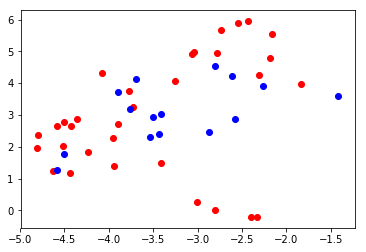

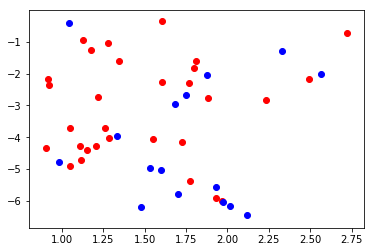

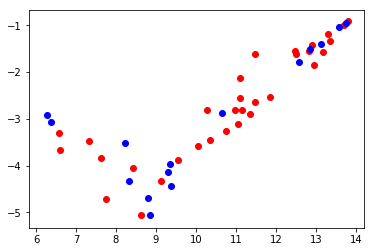

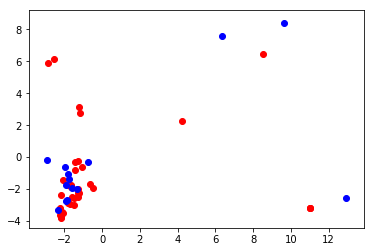

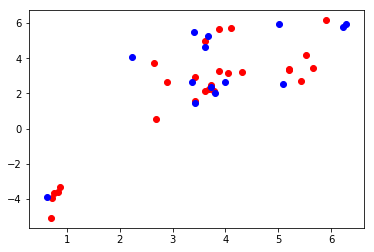

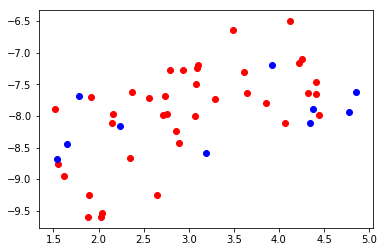

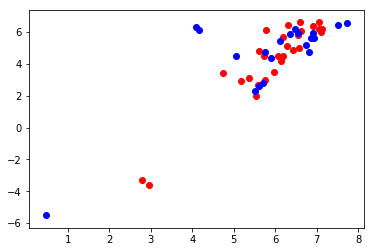

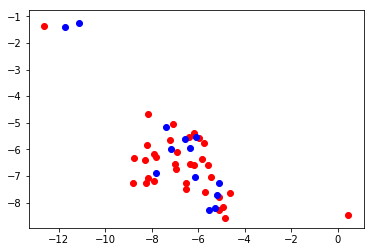

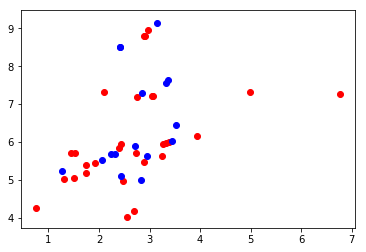

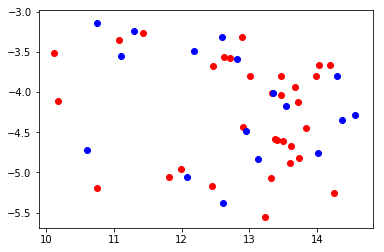

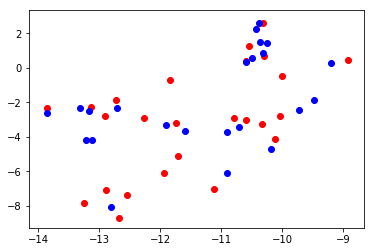

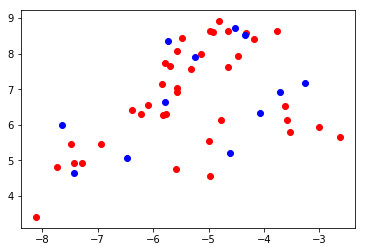

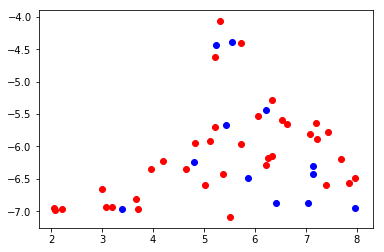

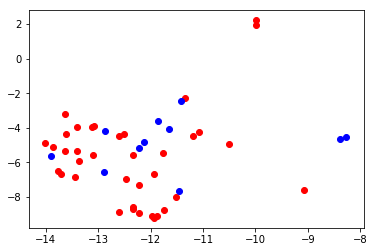

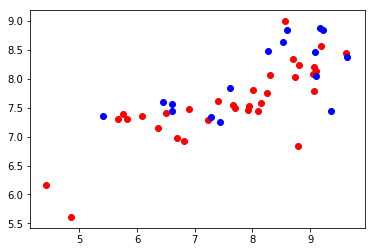

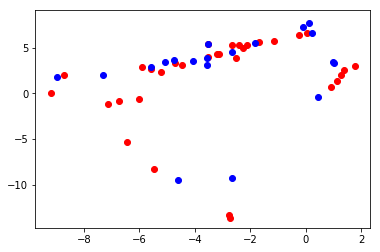

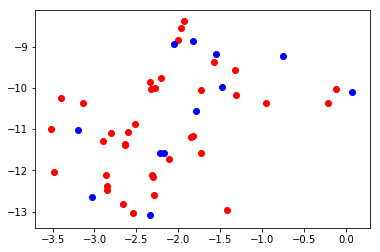

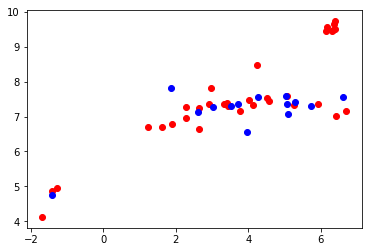

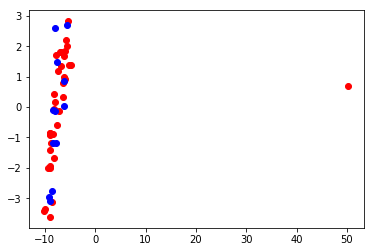

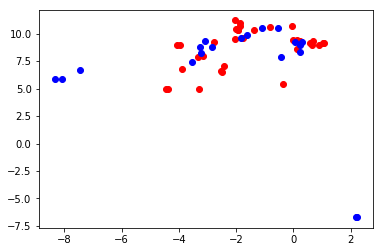

In [41]:
#plt.scatter(X_tsne[0:660, 0], X_tsne[0:660, 1], color = 'blue')
#plt.scatter(X_tsne[661:, 0], X_tsne[661:, 1], color='red')
plt.figure()

disptrainingData = X_tsne[0:660, :]
disptestData = X_tsne[660:, :]

for idx, cl in enumerate(np.unique(Y)):
    #plt.subplot(4, 5, idx+1)
    plt.figure()
    plt.scatter(x=disptrainingData[Y==cl,0], y=disptrainingData[Y==cl,1], color = 'red')
    plt.scatter(x=disptestData[results==cl,0], y=disptestData[results==cl,1], color = 'blue')

In [ ]:
import pandas as pd

out_df = pd.DataFrame(results)
out_df.to_csv('new-v-128.csv', index=True, header=False)

In [ ]:
trainingData.shape